# Costa Rican Household Poverty Level Prediction

Welcone to another Kaggle challenge! The objective of the Costa Rican Household Poverty Level Prediction contest is to develop a machine learning model that can predict the poverty level of household using individual and household characteristic. This 'data science for good' project offers the oppurtunity to put our skills towards a task more beneficial to society thant getting people to click on ads!

In this notebook, we will walk through a complete machone learning solution: first, get introduced to the problem, then perform a thorough EDA of the dataset, work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model and finally, inspect the outputs of the model and draw conclusions. While this notebook may not get us to the top of the learderboard, it is meant to be used as a teaching tool to give you a solid foundation to build on for future machine learning projects. Kaggle projects can teach us a lot about machine learning, but several of the stratgies used to get to the very top of the leaderboard are not best practices, so here we'll stick to building a very good - although not quite first place - machine learning solution. While Kaggle projects are competitions, I think they are best described as a machine learning education disguised as a contest!

If you are looking for follow upo this work, I have additional work including a kernel on using Automated Feature Engineering with Featuretools for this problem (with slightly higher leaderboard score). 

# Problem and Data Explanation
The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of i1 is the most extreme poverty.

This is a supervised multi-class classification machine learning problem:
* Supervised: provided with the labels for the training data
* Multi-class classification: LAbels are discrete values with 4 classes

**Objective**
The objective is to predict poverty on household level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but 'ONLY the heads of househild are used in scoring' which means we want to predict poverty on a household basis.

Important note: while all members of a household shild have the same label in the training data, there are errors where individuals in the same household have different labels. in these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentescol == 1.0. We will cover hot to correct this in the notebook ( for male info take a look at the competition main discussion ).

The Target values represent poverty levels as follows:
1 = extrme poverty
2 = moderate poverty
3 = vulnerable households
4 = non vulnerable households

The explanation for all 143 columns can  be found in the competition documentation, but a few to note are below:
- Id: a unique identifier for each individual, this shild not be a feature that we use!
- idhogar: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
- parentesco1: indicates if this person is the head of the household.
- Target: the label, which shold be equal for all members in a household

When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. These issues with the data are completely typical of real-world data and hence this problem is great preparation for the datasets you'll encounter in a data science hob!

# Metric
Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessd by the Macro F1 Score. You may be familiar with the standard F1 score for binary classification problems which is the mharmonic mean of percision and recall.

For multi-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class without taking into account label imbalances.

In other words, the number of occurences of each label does not figure into the calculation when using macro (while it odes when using the 'weighted' score). For more information on the differences, look at the Scikit-Learn Documentation for F1 Score on this Stack Exchange question and answers. If we want to assess out performance, we can use the code:

from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro')

For this problem, the labels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change! In your own work, you wnat to be aware of label imbalances and choose a metric accordingly.

# Roadmap
The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evaluate numerous models before choosing one as the 'best' and after build a model, we want to investigate the predictions. Our roadmap is therefore as follows:
1. Understand the problem (we're almost there already)
2. EDA
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try more complex machine learning models
6. Optimize the selected model
7. Investigate model predictions in context of problem
8. Draw conclusion and lay out next steps

The steps laid out above areiterative meaning that while we will go through them one at a time., we might go back to an earlier step and revisit some of our decision. In general, data science is a non-linear pracice where we are constantly evaluating our past decisions and making improvemnets. In particular, feature engineering, modeling, and optimization are steps that we often repeat because we never know if we got them right the first time!

# Getting Started
We have a pretty good grasp of the problem, so we'll move into the EDA and feature engineering. For the EDA, we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures).

Once we have a good grasp of the data and any potentially useful relationships, we can do some feature engineering (the most important part of the machine learning pipeline) and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on!

With all that info in mind (don't worry if you haven't got all the details), let's get started!

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [3]:
pd.options.display.max_columns = 150

# Read in data and look at summary information
train = pd.read_csv('../input/household/train.csv')
test = pd.read_csv('../input/household/test.csv')
train.head(20)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.00,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.00,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.00,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.00,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.00,1369,4
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,38,121,1444,16,121,4,1.777778,1.0,121.00,1444,4
6,ID_e9e0c1100,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,2,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,1,0,0,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,8,4,64,16,121,4,1.777778,1.0,121.00,64,4
7,ID_3e04e571e,130000.0,1,2,0,1,1,0,NaN,0,1,1,2,1,3,2,2,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,

That gives us a look at all of the columns which don't appear to be in any order. To get a quick overview of the data we use df.info()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or ordinal variables with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Let's glance at the test data which has many more rows than the train. It does have one fewer column because there's no Target!

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


# Integer columns
Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

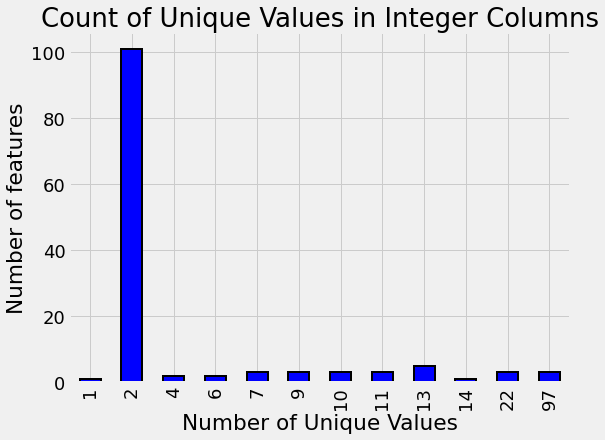

In [14]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8,6), edgecolor='k', linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Number of features')
plt.title('Count of Unique Values in Integer Columns')
plt.show()

The columns with only 2 unique values represent Booleans. In a lot of cases, this boolean information is already on a household level. For example, the refrig column says wheter or not the household has a refrigerator. When it comes time to make features from the Boolean columns that are on the household level, we will not neet to aggregate these. However, the Boolean columns that are on the individual level will need to be aggregated.

# Float Columns
Another columns type is floats which represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an OrderedDict to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

The following graphs shows the distributions of the float columns colored by the value of the Target. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

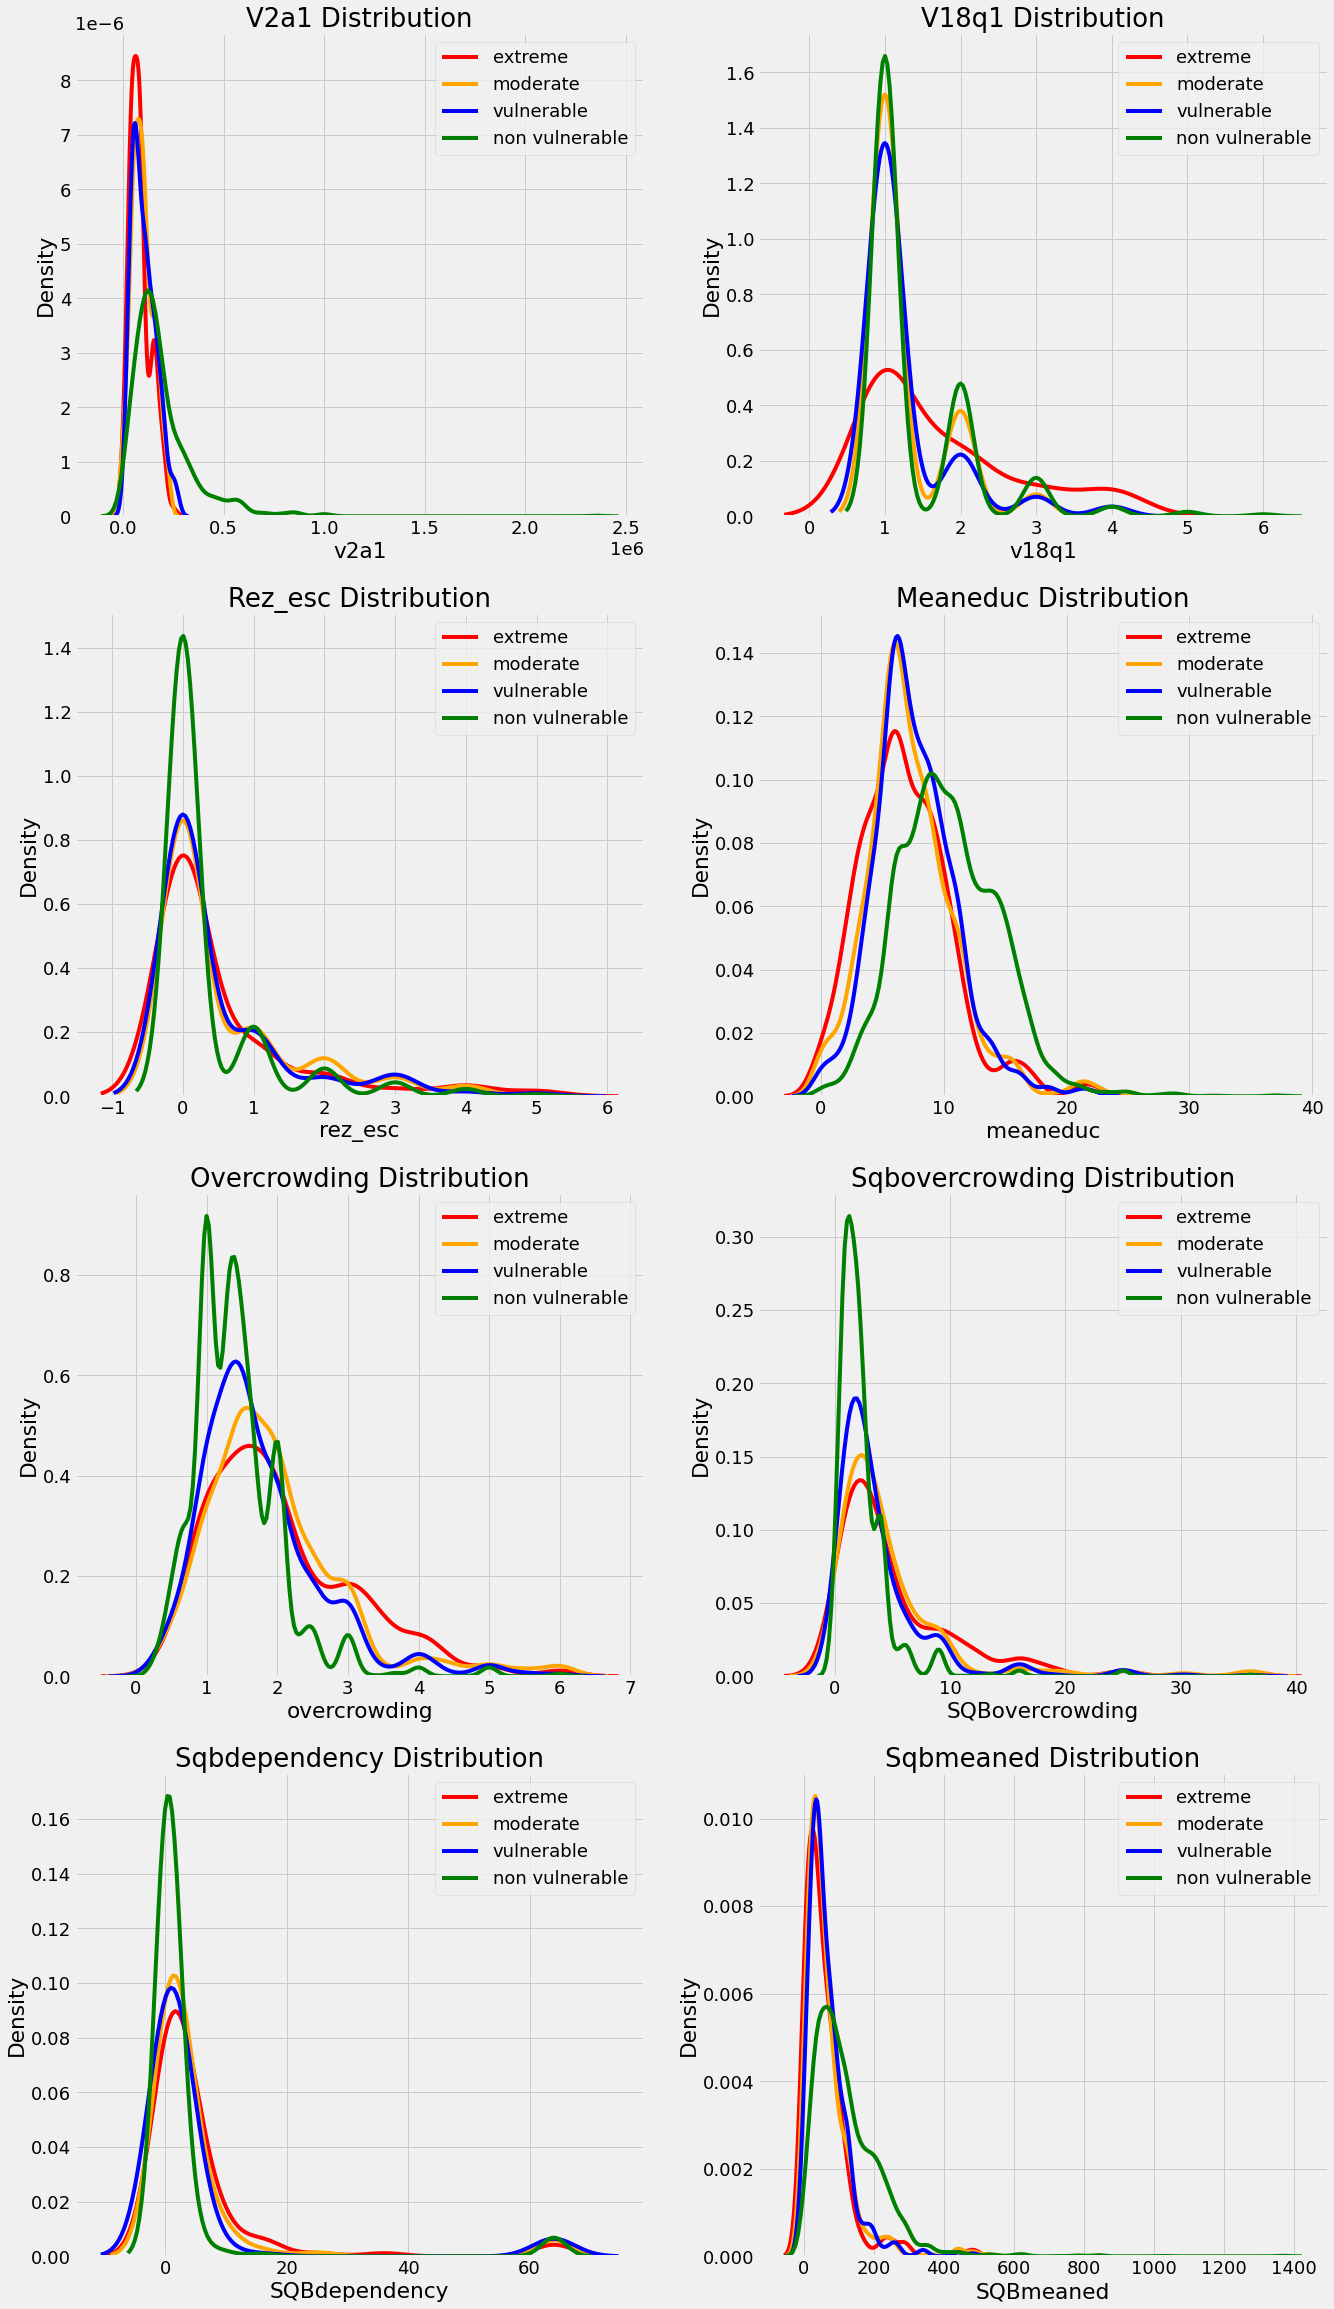

In [16]:
from collections import OrderedDict

plt.figure(figsize=(20,16))

# Color mapping
colors = OrderedDict({
    1:'red',
    2:'orange',
    3:'blue',
    4:'green'
})

poverty_mapping = OrderedDict({
    1:'extreme',
    2:'moderate',
    3:'vulnerable',
    4:'non vulnerable'
})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4,2, i+1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        sns.kdeplot(train.loc[train['Target']==poverty_level, col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    
plt.subplots_adjust(top=2)

Later on we'll calculate correlations between the variables and the Target to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most 'relevant' to a model. For example, the meaneduc, representing the average education of the adults in the household appears to be related to the poverty level: a higher average adult education leads to higher values of the target which are less severe level of poverty. The theme of the important education is one we will come back to again and again in this notebook!

# Object Columns
The last column type is object which we can view as follows.

In [17]:
train.select_dtypes('object').head(10)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no
5,ID_ec05b1a7b,2b58d945f,yes,11,no
6,ID_e9e0c1100,2b58d945f,yes,11,no
7,ID_3e04e571e,d6dae86b7,yes,9,no
8,ID_1284f8aad,d6dae86b7,yes,9,no
9,ID_51f52fdd2,d6dae86b7,yes,9,no


The Id and idhogar object types make sense because there are identifying variables. However, the other columns seem to be a mix of strings and numbers which we'll need to address before doing machine learning. According to the documentation for these columns:
* dependency: dependency rate, calculated = (numberof members of the household younger than 19 or older than 64) / (number of member of household between 19 and 64)
* edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=0 and no=0

These explanations clear up the issue. For these three variable, 'yes'=1 and 'no'=0. We can correct the variables using a mapping and convert to floats.

In [19]:
mapping = {'yes':1, 'no':0}

# Apply same operation to both train and test
for df in [train, test]:
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    
train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


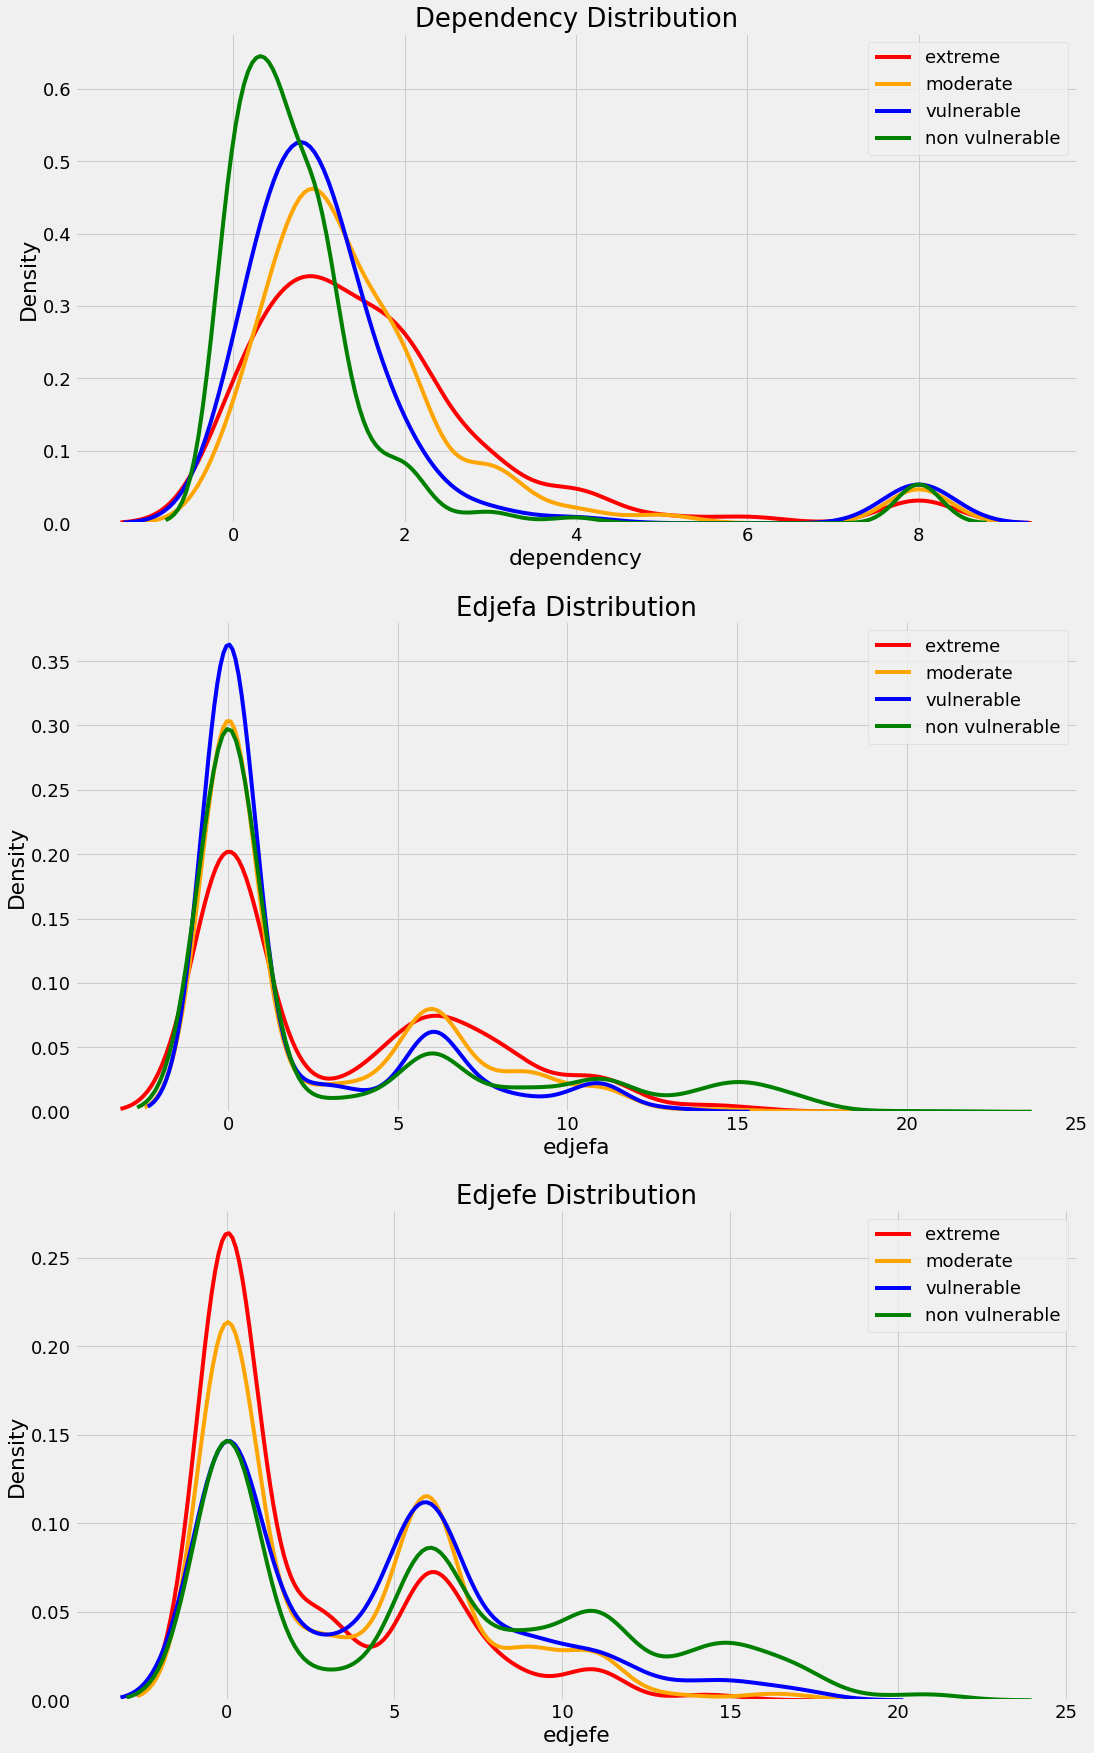

In [21]:
plt.figure(figsize=(16,12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3,1,i+1)
    for poverty_level, color in colors.items():
        # plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target']==poverty_level, col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    
plt.subplots_adjust(top=2)

These variables are now correctly represented as numbers and can be fed into a machine learning model.

To make operations like that above a little easier, we'll join together the training and testing dataframe. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate out the sets based on the Target.

In [24]:
# Add null Target columns to Test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)
data.head(10)

C:\Users\smsm8\AppData\Local\Temp\ipykernel_19468\2368094366.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(test, ignore_index = True)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,0.0,10.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8.0,12.0,0.0,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4.0
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8.0,0.0,11.0,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4.0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4.0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4.0
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,38,121,1444,16,121,4,1.777778,1.0,121.0,1444,4.0
6,ID_e9e0c1100,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,2,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,1.0,11.0,0.0,11.0,0,1,0,0,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,8,4,64,16,121,4,1.777778,1.0,121.0,64,4.0
7,ID_3e04e571e,130000.0,1,2,0,1,1,0,NaN,0,1,1,2,1,3,2,2,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0

# Exploring Label Distribution
Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where parentesco1==1 because this is the head of household, the correct label for each house hold.

The bar plot below shows the distribution of training labels (since there are no testing labels).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

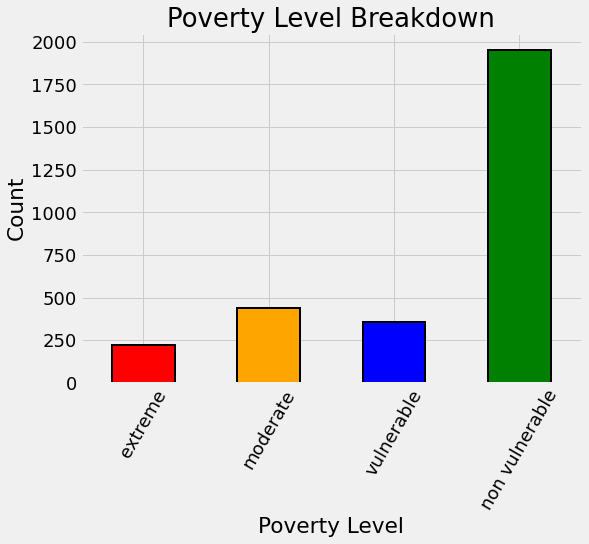

In [34]:
# Heads of household
heads = data.loc[data['parentesco1']==1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurences of each label
label_counts.plot.bar(figsize=(8,6),
                     color = colors.values(),
                     edgecolor='k', linewidth=2)
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()],
          list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown')
label_counts

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the macro f1 score as the metric instead of weighted f1!). There are many more households that classify as non vulnerable than in any other category. The extreme poverty class is the smallest (I guess this should make us optimistic!).

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: If we are classifying poverty and we see far more cases of no poverty than extrme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling (which is covered in more advanced notebooks).

# Addressing Wrong Labels
As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/error. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because individuals in the same household have a different poverty level. We're not told why this may be the case, but we are told to use the head of household as the true label.

That information makes our job much easier, but in a real-world proble, we would have to figure out the reason Why the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

# Identify Errors
First we need to find the errors before we can correct them. To find the households with different labels for family members, we can group the data by the household and then check if there is only one unique value of the Target.

In [43]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)

# Household where targets are not all equal
not_equal = all_equal[all_equal != True]
print(f'There are {len(not_equal)} households where the family members do not all have the same target.')

There are 85 households where the family members do not all have the same target.


In [54]:
# Let's look at one example
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


The organizers tell us that the correct label is that for the head of household, where parentesco1==1. For this household, the correct label is 3 for all members. We can correct this by reassigning all the individuals in this household the correct poverty level. In the real-world, you might have to make the tough decision of how to address the problem by yourself ( or with the help of your team ).

# Families without Heads of Household
We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you may ask: 'What if there are households without a head of household? And what if memebers of those household have differing values of the label?'

Well, since you asked, let's investigate exactly that question!

In [59]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find househilds without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [62]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


Well that's a relief! This means that we don;y have to worry about a household both where there is no head AND the members have different values of the label! For this problem, according to the organizers, if a household does not have a head, then there is no true label. Therefore, we actually won't use any of households without a head for training. Nonetheless, it's still a good exercised to go through this process of investigating the data!

# Correct Errors
Now we can correct labels for the households that do have a head AND the members have different poverty levels.

In [67]:
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & train['parentesco1']==1.0]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar']==household, 'Target'] = true_target
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)

# Households where targets are not all equal
not_equal = all_equal[all_equal!=True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


Since we are only going to use the heads of household for the labels, this step is not completely necessary but it shows a workflow for correcting data errors like you may encounter in real life. Don't consider it extra work, just practice for your career!

# Missing Variables
One of the most important steps of EDA is finding missing values in the data and determining how to handle them. Missing vlaues have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.

First we can look at the percentage of missing values in each column.

In [71]:
# Numberof missing in each column
missing = pd.DataFrame(data=data.isnull().sum()).rename(columns={0:'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending=False).head(10).drop('Target', axis=0)

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


We don't have to worry about the Target because we made that NaN for the test data. However, we do need to address the other 3 columns with a high percentage of missing values.

*v18q1*: Number of tablets

Let's start with v18q1 which indicates the number of tablets woned a famliy. We can look at the value counts of this variable. Since this is a household variable, it only makes sense to look at it on a husehold level, so we'll only select the rows for the head of household.

# Function to Plot Value Counts
Since we might want to plot value counts for different columns, we can write a simple function that will do it for us!

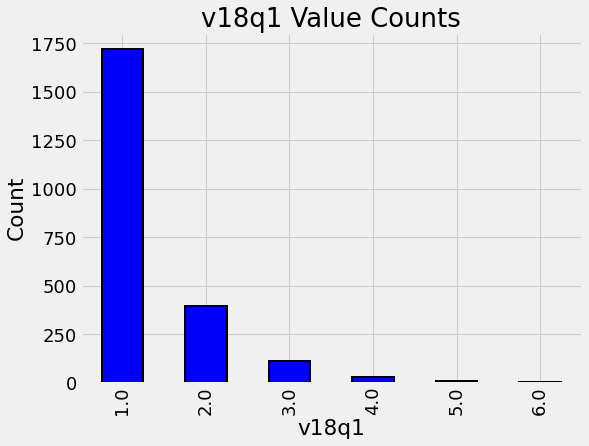

In [74]:
def plot_value_counts(df, col, heads_only=False):
    """
    Plot value counts of a column, optionally with only the heads of a house hold
    """
    if heads_only:
        df = df.loc[df['parentesco1'==1]].copy()
        
    plt.figure(figsize=(8,6))
    df[col].value_counts().sort_index().plot.bar(color='blue',
                                                edgecolor='k',
                                                linewidth=2)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'{col} Value Counts')
    plt.show()
plot_value_counts(heads, 'v18q1')

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing. In this case, it could be that families with a nan in this category just do not own a tablet! If we look at the data definitions, we see that v18q indicates whether or not a family onws a tablet. We should investigate this column combined with the nunber of tablets to see if our hypothesis holds.

We can groupby the value of v18q (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for v18q1. This will tell us if the null values represent that the family does not own a tablet.

In [85]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Well, that solves the issue! Every family that has nan for v18q1 does not own a tablet. Therefore, we can fill in this missing value with zero.

In [86]:
data['v18q1'] = data['v18q1'].fillna(0)

*v2a1*: Montly rent payment
The next missing column is v2a1 which represents the montly rent payment.

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of topovivi_, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthly rent payment.

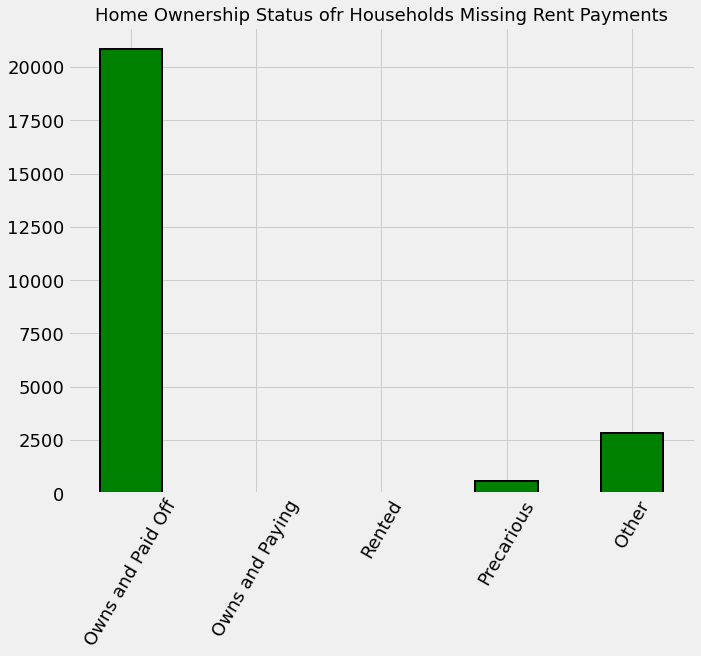

In [95]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(
    figsize=(10,8),
    color='green',
    edgecolor='k',
    linewidth=2
)

plt.xticks([0,1,2,3,4],
          ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation=60)

plt.title('Home Ownership Status ofr Households Missing Rent Payments', size=18)
plt.show()


We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few situations, we are not sure of the reason for the missing information.

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other home, we can leave the missing values to be imputed, but we'll ad a flag (Boolean) column indicating that these house holds had missing values.

In [96]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1']==1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

*rez_esc*: years behind in school

The last column with a high percentage of missing values is rez_esc indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [101]:
data.loc[data['rez_esc'].notnull(), 'age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value.

In [102]:
data.loc[data['rez_esc'].isnull(), 'age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

If we read through some of the discussion for this competition, we learn that this variable only defined for individual between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [108]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age']>19)|(data['age']<7))&(data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

There is also one outlier in the rez_esc column. Again, if we read through the competition discussions, we learn that the maximum value for this variable is 5.
Therefore any values above 5 shild be set to 5

In [111]:
data.loc[data['rez_esc']>5, 'rez_esc']=5

# Plot Two Categorical Variables
To show how two categorical varaibles interact with one another, there are a number of plotting options: scatterplts, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I worte the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

In [115]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         text = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

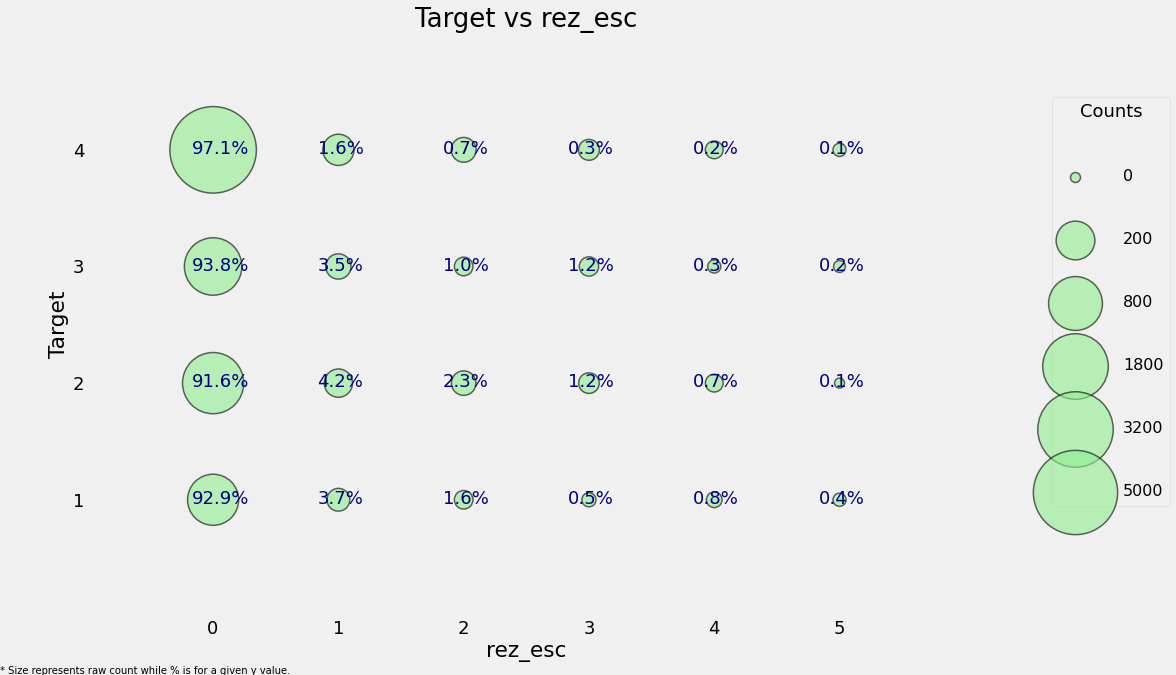

In [116]:
plot_categoricals('rez_esc', 'Target', data);

The size of the markers represents the raw count. To read the plot, choose a given y-value and then read across the row. For example, with a poverty level of 1, 93% of individuals have no years behind with a total count of around 800 individuals and about 0.4% of individuals are 5 years behind with about 50 total individuals in this category. This plot attempts to show both the overall counts and the within category proportion; it's not perfect, but I gave it a shot!

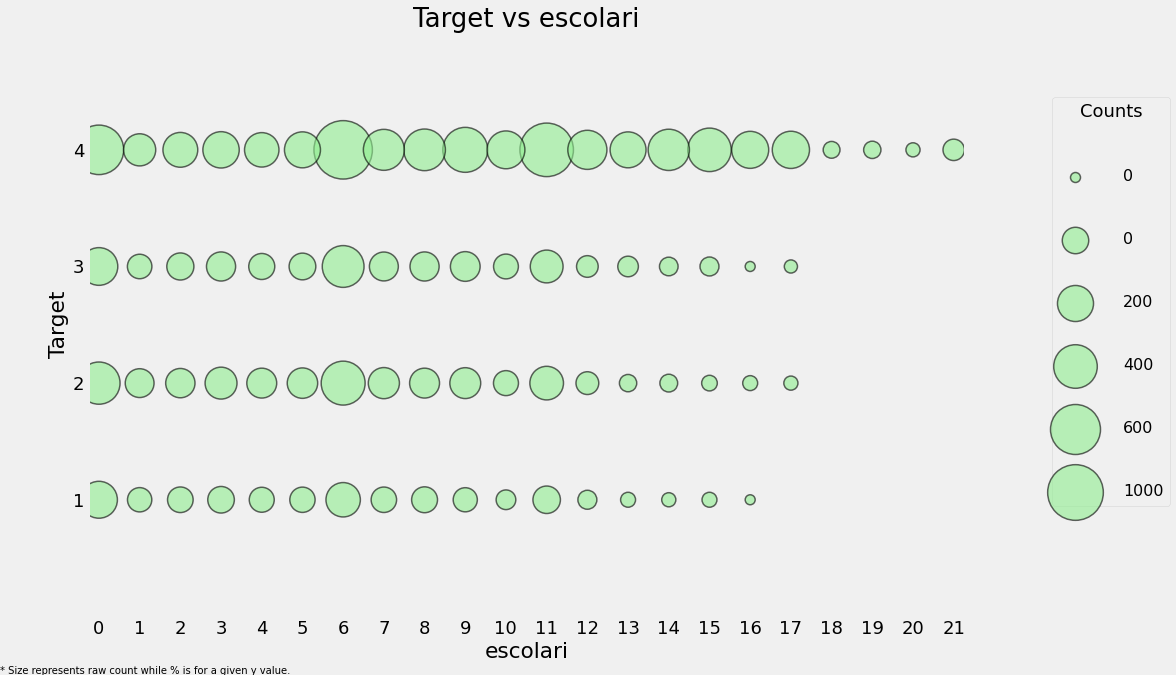

In [117]:
plot_categoricals('escolari', 'Target', data, annotate = False)

The remaining missing values in each column will be filled in, a process known as Imputation. There are several types of impitation commonly used, and oone of the simplest and most effective methods is to fill in the missing values with the median of the column.

As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing.

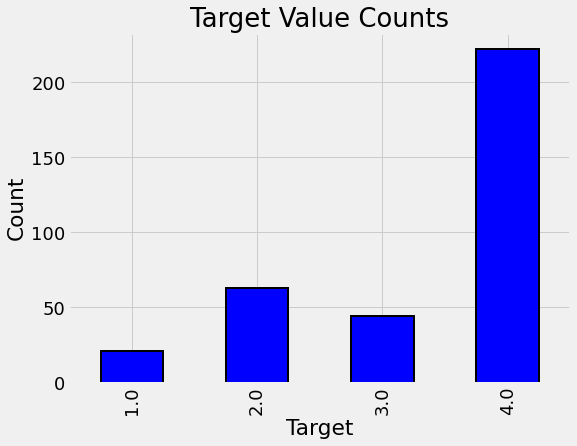

In [119]:
plot_value_counts(data[data['rez_esc-missing']==1],'Target')

The distribution here seems to match that for all the data at large.

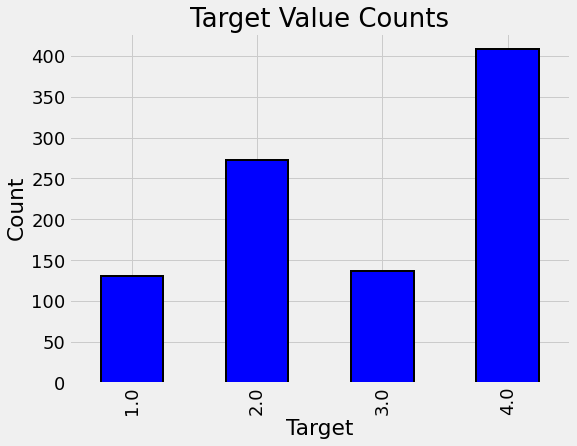

In [120]:
plot_value_counts(data[(data['v2a1-missing']==1)],'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty.

*This represents an important point*: sometimes the missing information is just as important as the information you are given.